In [1]:

%load_ext autoreload
%autoreload 2

import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import pymudokon as pm

jax.config.update('jax_platform_name', 'cpu')

import pandas as pd
import numpy as np

In [2]:
# d = 1, rhop = 1, e = 0.7, mu = 0, K = 10^3, shear rate = 1
names = ["nu", "p", "s", "T", "I", "CN", "k"]
df_k3 = pd.read_table("./DATA_SS/k1ex.data",sep=" ", skiprows=2,nrows=21, names = names)
df_k4 = pd.read_table("./DATA_SS/k1ex.data",sep=" ", skiprows=26,nrows=21, names = names)
df_k5 = pd.read_table("./DATA_SS/k1ex.data",sep=" ", skiprows=50,nrows=21, names = names)
df_k6 = pd.read_table("./DATA_SS/k1ex.data",sep=" ", skiprows=74,nrows=26, names= names)
df_k7 = pd.read_table("./DATA_SS/k1ex.data",sep=" ", skiprows=103,nrows=21, names= names)
df_k8 = pd.read_table("./DATA_SS/k1ex.data",sep=" ", skiprows=127,nrows=21, names= names)

def df_format(df,d,K):
    df["pstar"] = df["p"]*(d/K)
    df["sstar"] = df["s"]*(d/K)
    df["qstar"] =  df["sstar"]*np.sqrt(3)
    df["mu"] = df["s"]/df["p"]
    df["e"] = 1./df["nu"] -1
    df["stiffness"] = K
    return df


df_k3 = df_format(df_k3,d=1,K=10**3)
df_k4 = df_format(df_k4,d=1,K=10**4)
df_k5 = df_format(df_k5,d=1,K=10**5)
df_k6 = df_format(df_k6,d=1,K=10**6)
df_k7 = df_format(df_k7,d=1,K=10**7)
df_k8 = df_format(df_k8,d=1,K=10**8)

dem_stiffness_all =[
    1e3,
    1e4,
    1e5,
    1e6,
    1e7,
    1e8
]

df_dem_all = [
    df_k3,
    df_k4,
    df_k5,
    df_k6,
    df_k7,
    df_k8
]

colors = ["red","blue","green","purple","orange","black"]

In [3]:
def run_model(K, nu_list):

    last_volume_fraction_stack = []
    last_mu_stack = []
    last_p_stack = []
    last_tau_stack = []
    for phi in nu_list:
        carry, accumulate = pm.simple_shear_wrapper(
            pm.MuISoft,
            [
                0.12,  # mu_s 0.381.. 
                0.55, # mu_d 0.643..
                0.2, # I0
                0.634, # phi_c
                3.28, # I_phi
                1, # rho p (kg/m^3)
                1, # d (m)
                0.33, # p_phi
                # # 0.01,
                # 1.9,
                0.33, # p0
                # 0.9, # p0
                # 10**3 # K
                K
            ],
            target=1.0,
            dt=1,
            stress_ref= -1000.0 * jnp.eye(3).reshape(3, 3),
            # volume_fraction=0.672,
            volume_fraction=phi,
            keys=("stress", "strain_rate","volume_fraction"),
            store_every = 1,
            is_target_strain_rate= False,
            total_time=1.0,
            
        )
        
        stress_stack, strain_rate_stack,  volume_fraction_stack = accumulate
        
        volume_fraction_stack = jnp.ones(len(stress_stack))*phi
        
        pressure_stack = pm.get_pressure(stress_stack)
        
        q_stack = pm.get_q_vm(stress_stack)
        tau_stack = q_stack/jnp.sqrt(3)

        last_tau_stack.append(tau_stack[-1])
        

        mu_stack = tau_stack/pressure_stack
        last_mu_stack.append(
            mu_stack[-1]
        )
        
        last_volume_fraction_stack.append(
            volume_fraction_stack[-1]
        )
        p_stack = pm.get_pressure(stress_stack)
        last_p_stack.append(
            p_stack[-1]
        )
        
    return (
    jnp.array(last_volume_fraction_stack),
    jnp.array(last_mu_stack),
    jnp.array(last_p_stack),
    jnp.array(last_tau_stack)
    )



# ax.plot(jnp.array(last_volume_fraction_stack),jnp.array(last_p_stack)/10**3, ls="-",lw=2, label="Jop")

# df_k8.plot(y="pstar", x="nu", kind="scatter", ax = ax, label="K = 10^8")
# df_k3.plot(y="pstar", x="nu", kind="scatter", ax=ax,c="r", label="K = 10^3")

# ax.set_yscale("log")
# ax.set_xlim(0.5,0.7)


(0.5, 0.6785000175237655)

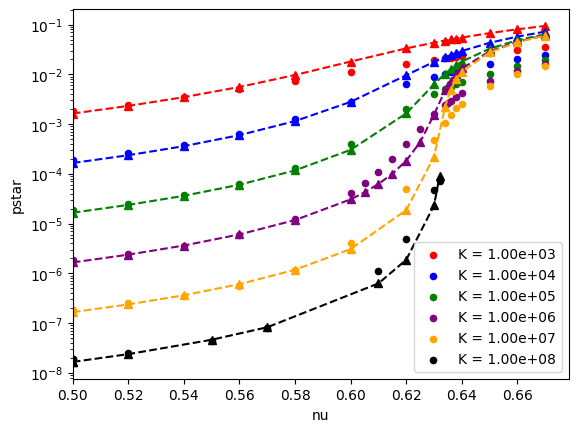

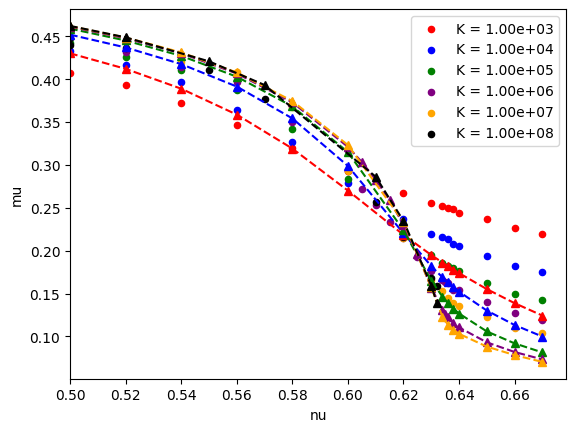

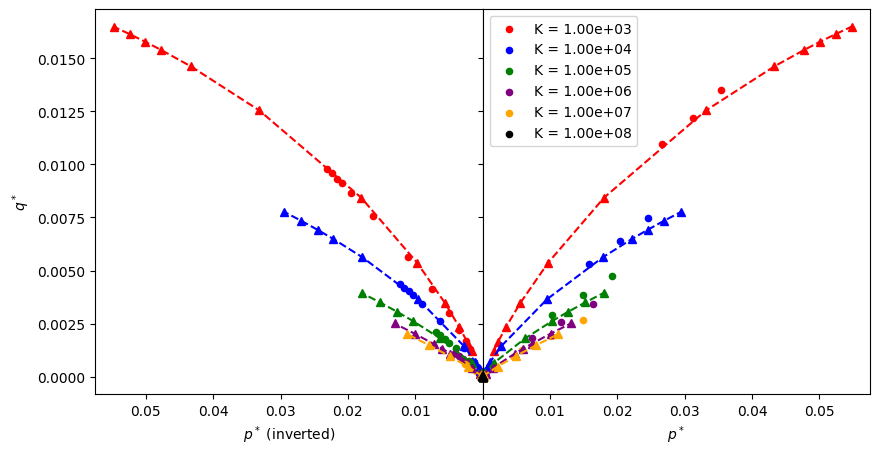

In [4]:
fig_p_nu, ax_p_nu = plt.subplots(1,1)
fig_mu_nu, ax_mu_nu = plt.subplots(1,1)

fig,ax = plt.subplots(1,2,sharey=True,figsize=(10,5))
fig.subplots_adjust(wspace=0.)

phi_c = 0.648

lower= 0.5

for i,df_raw in enumerate(df_dem_all):
    
    df = df_raw.loc[df_raw["nu"]>=lower]
    
    K = dem_stiffness_all[i]
    
    nu_vals = df["nu"].values
    nu, mu, p, tau  = run_model(K,nu_vals)
    q = tau*np.sqrt(3)
    
    ax_p_nu.plot(nu,p/K, label=f"K = {K:.2e}", c=colors[i],marker="^",ls="--")
    ax_mu_nu.plot(nu,mu, label=f"K = {K:.2e}", c=colors[i],marker="^",ls="--")
    
    df.plot(x="nu",y="pstar",ax=ax_p_nu,c=colors[i],label=f"K = {K:.2e}",kind="scatter")
    df.plot(x="nu",y="mu",ax=ax_mu_nu,c=colors[i],label=f"K = {K:.2e}",kind="scatter")
    
    
    id_above = np.where(nu >= phi_c)[0]
    id_bellow = np.where(nu < phi_c)[0]

    ax[0].plot(p[id_bellow]/K,q[id_bellow]/K, label=f"K = {K:.2e}", c=colors[i],marker="^",ls="--")
    ax[1].plot(p[id_bellow]/K,q[id_bellow]/K, label=f"K = {K:.2e}", c=colors[i],marker="^",ls="--")
    
    
    df_above = df.loc[df["nu"]>=phi_c]
    df_bellow = df.loc[df["nu"]<phi_c]
    df_bellow.plot(
        x="pstar",
        y="qstar",ax=ax[0],
        kind="scatter",
        c=colors[i]
        )

    df_above.plot(
        x="pstar",
        y="qstar",
        ax=ax[1],
        c=colors[i],
        label=f"K = {K:.2e}", kind="scatter"
        )

ax_p_nu.set_yscale("log")


ax[0].set_xlim(0,None)
ax[0].invert_xaxis()
ax[0].set_ylabel(r"$q^*$")
ax[0].set_xlabel(r"$p^*$ (inverted)")

ax[1].set_xlim(0,None)
ax[1].set_xlabel(r"$p^*$")

ax_p_nu.set_xlim(lower,None)
ax_p_nu.set_yscale("log")
ax_mu_nu.set_xlim(lower,None)


In [5]:
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[1].set_xscale("log")
ax[1].set_yscale("log")